Dicoding IDCamp 2024: Machine Learning Terapan

Model Sistem Rekomendasi

Nama: Nugroho Adi Wirapratama

Email: adiwira009@gmail.com

LinkedIn: https://www.linkedin.com/in/nug-adiwira/

Github: https://github.com/adiwira09

# Download dataset

In [ ]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("aprabowo/indonesia-tourism-destination")
shutil.move(path, '/content')

100%|██████████| 158k/158k [00:00<00:00, 40.5MB/s]

Extracting files...


'/content/1'

Dataset information:
1. tourism_ with _id.csv : berisi informasi tentang objek wisata di 5 kota besar di Indonesia dengan total sekitar 400 tempat wisata.
2. user.csv : berisi data pengguna dummy untuk membuat fitur rekomendasi berdasarkan pengguna.
3. tourism_rating.csv : berisi 3 kolom, yaitu pengguna, tempat wisata, dan rating yang diberikan, digunakan untuk membuat sistem rekomendasi berdasarkan rating.
4. package_tourism.csv : berisi rekomendasi tempat wisata terdekat berdasarkan waktu, biaya, dan rating.

# Import library

In [ ]:
!pip install Sastrawi -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.26.4 -q

!pip install scikit-surprise==1.1.4 -q

Restart kernel terlebih dahulu

In [ ]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.accuracy import rmse, mae

import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load data

In [ ]:
tourism = pd.read_csv('indonesia-tourism-destination/tourism_with_id.csv')
rating = pd.read_csv('indonesia-tourism-destination/tourism_rating.csv')

In [ ]:
tourism = pd.read_csv('1/tourism_with_id.csv')
rating = pd.read_csv('1/tourism_rating.csv')

In [ ]:
# Merge dataset
df = pd.merge(rating, tourism, on='Place_Id', how='left')

# Delete kolom yang tidak diketahui dan tidak diperlukan
df = df.drop(['Unnamed: 11','Unnamed: 12', 'Time_Minutes', 'Coordinate',	'Lat',	'Long', 'Place_Ratings'], axis=1)

In [ ]:
df.shape

(10000, 8)

# Data understanding

In [ ]:
df.head()

,User_Id,Place_Id,Place_Name,Description,Category,City,Price,Rating
0,1,179,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,Yogyakarta,75000,4.6
1,1,344,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari,Semarang,3000,4.1
2,1,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5
3,1,373,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000,4.5
4,1,101,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,Yogyakarta,0,4.0


**Kolom Information:**
- User_Id : user_id.
- Place_Id : id dari Place_Name.
- Place_Name : nama tempat destinasi.
- Description : teks deskripsi tentang destinasi.
- Category : kategori dari destinasi.
- City : lokasi kota dari destinasi.
- Price : harga tiket masuk destinasi.
- Rating : rating yang diberikan User_Id terhadap destinasi.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   User_Id      10000 non-null  int64  
 1   Place_Id     10000 non-null  int64  
 2   Place_Name   10000 non-null  object 
 3   Description  10000 non-null  object 
 4   Category     10000 non-null  object 
 5   City         10000 non-null  object 
 6   Price        10000 non-null  int64  
 7   Rating       10000 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 625.1+ KB


In [ ]:
df.describe()

,User_Id,Place_Id,Price,Rating
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,23725.500000,4.445700
std,86.137374,126.228335,62633.550481,0.207345
min,1.000000,1.000000,0.000000,3.400000
25%,77.000000,108.750000,0.000000,4.400000
50%,151.000000,220.000000,5000.000000,4.500000
75%,226.000000,329.000000,20000.000000,4.600000
max,300.000000,437.000000,900000.000000,5.000000


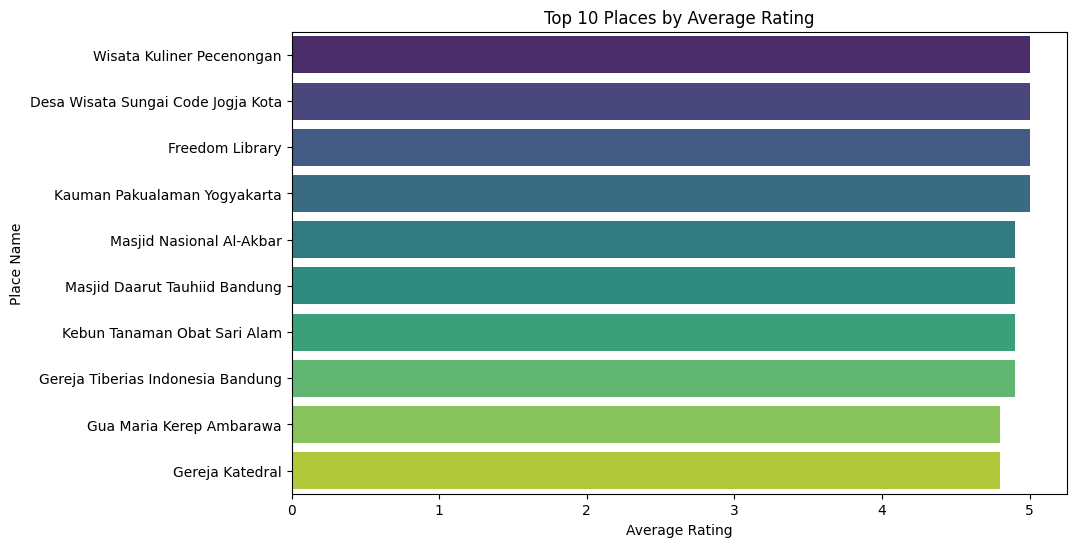

In [ ]:
top_places_rating = df.groupby('Place_Name')['Rating'].mean().sort_values(ascending=False).head(10)

# Visualizing with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_places_rating.values, y=top_places_rating.index, palette='viridis')
plt.title('Top 10 Places by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Place Name')
plt.show()

Wisata Kuliner Pecenongan menduduki peringkat pertama dengan rating tertinggi, diikuti oleh Desa Wisata Sungai Code Jogja Kota dan Freedom Library.

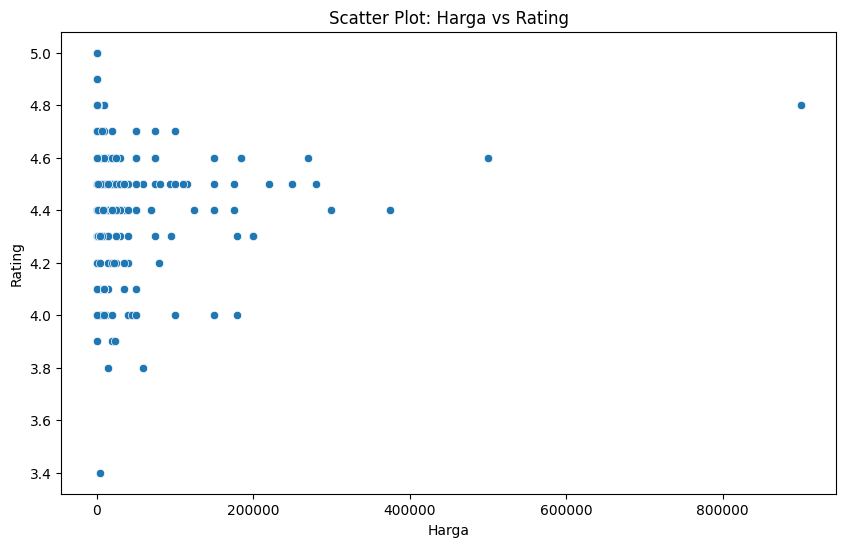

In [ ]:
df_rating_price = df.groupby('Place_Name').agg(
    avg_rating=('Rating', 'mean'),
    price=('Price', 'first')
).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='avg_rating', data=df_rating_price)
plt.title('Scatter Plot: Harga vs Rating')
plt.xlabel('Harga')
plt.ylabel('Rating')
plt.show()

Dari scatter plot, terlihat bahwa meskipun harga bervariasi, sebagian besar destinasi memiliki rating tinggi (di atas 4), namun tidak ada pola yang jelas antara harga dan rating.

In [ ]:
import statsmodels.api as sm

# Menambahkan konstanta untuk model regresi
X = sm.add_constant(df_rating_price['price'])
y = df_rating_price['avg_rating']

# Membuat model regresi
model = sm.OLS(y, X).fit()

# Melihat hasil ringkasan model regresi
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2351
Date:                Sat, 19 Apr 2025   Prob (F-statistic):              0.628
Time:                        03:59:41   Log-Likelihood:                 65.495
No. Observations:                 437   AIC:                            -127.0
Df Residuals:                     435   BIC:                            -118.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4410      0.011    416.857      0.0

Dalam analisis regresi, hasil menunjukkan bahwa koefisien untuk harga sangat kecil (7.296e-08), dan p-value sebesar 0.628 menunjukkan bahwa harga tidak berpengaruh signifikan terhadap rating destinasi wisata. Nilai R-squared yang sangat rendah (0.001) juga menegaskan bahwa harga hanya menjelaskan sedikit sekali variasi dalam rating.

**Harga tidak menjadi faktor yang signifikan dalam menentukan rating destinasi wisata.**

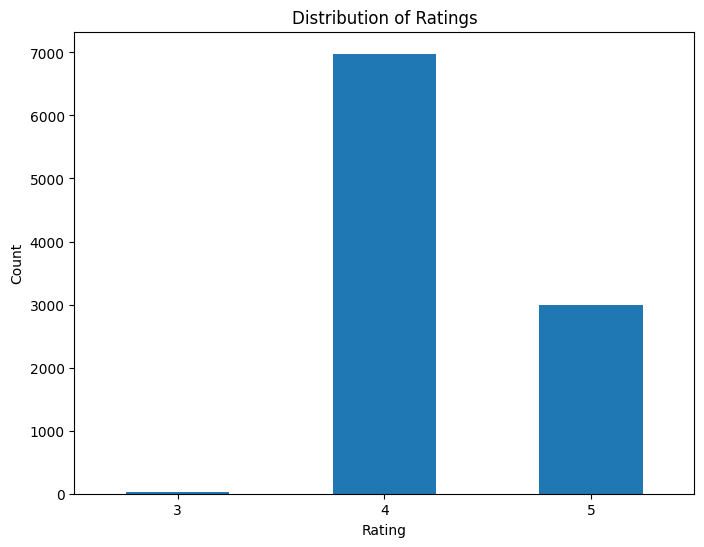

In [ ]:
ratings = df['Rating'].round().astype(int)
rating_counts = pd.Series(ratings).value_counts().sort_index()

plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Sebagian besar rating yang diterima adalah rating 4, dengan jumlah yang sangat dominan hampir mencapai 7.000. Sementara itu, rating 5 juga mendapatkan jumlah yang cukup besar, meskipun jauh lebih sedikit dibandingkan rating 4. Di sisi lain, rating 3 hampir tidak terlihat di grafik, menandakan bahwa sedikit sekali tempat yang menerima penilaian di sekitar nilai ini.

# Data preparation

In [ ]:
print("Sebelum dilakukan data preparation")

baris, kolom = df.shape
print(f"Jumlah baris: {baris}")
print(f"Jumlah kolom: {kolom}")

Sebelum dilakukan data preparation
Jumlah baris: 10000
Jumlah kolom: 8


## Menghapus kolom tidak relevan

In [ ]:
df = df.drop(['Price'], axis=1)

- Kolom price tidak digunakan oleh karena itu dihapus.
- Price tidak memberikan korelasi terhadap rating yang diberikan oleh user terhadap destinasi.

In [ ]:
# cek missing value
df.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Rating,0


Tidak ada baris yang memiliki NaN value

## Drop/delete duplikat value

In [ ]:
jumlah_duplikat = df.duplicated().sum()
persentase_duplikat = (jumlah_duplikat / len(df)) * 100

print(f'Data duplikat: {jumlah_duplikat} atau {persentase_duplikat:.2f}%')

Data duplikat: 403 atau 4.03%


- Terdapat 403 data duplikat, yang merupakan 4.03% dari keseluruhan data.
- Data duplikat secara keseluruhan, bahkan secara "Description" benar-benar sama.

Oleh karena itu kita hapus semua data yang duplikat.

In [ ]:
df_clean = df.drop_duplicates()

## Processing text

In [ ]:
stop_words = set(stopwords.words('indonesian'))
stemmer = StemmerFactory().create_stemmer()

In [ ]:
def preprocess(text):
    text = text.lower()                                  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)                  # Remove punctuation
    text = re.sub(r'\d+', '', text)                      # Remove numbers (optional)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    text = ' '.join(tokens)
    text = stemmer.stem(text)                            # Stemming
    return text

In [ ]:
df_clean['Description'] = df_clean['Description'].apply(preprocess)
df_clean['City'] = df_clean['City'].apply(preprocess)
df_clean['Category'] = df_clean['Category'].apply(preprocess)

In [ ]:
df_clean.head()

,User_Id,Place_Id,Place_Name,Description,Category,City,Rating
0,1,179,Candi Ratu Boko,situs ratu baka candi boko hanacaraka bahasa j...,budaya,yogyakarta,4.6
1,1,344,Pantai Marina,pantai marina bahasa jawa translit pasisir mar...,bahari,semarang,4.1
2,1,5,Atlantis Water Adventure,atlantis water adventure kenal atlantis ancol ...,taman hibur,jakarta,4.5
3,1,373,Museum Kereta Ambarawa,museum kereta api ambarawa bahasa inggris indo...,budaya,semarang,4.5
4,1,101,Kampung Wisata Sosro Menduran,kampung wisata sosromenduran kampung wisata un...,budaya,yogyakarta,4.0


In [ ]:
print("Setelah dilakukan data preparation")

baris, kolom = df_clean.shape
print(f"Jumlah baris: {baris}")
print(f"Jumlah kolom: {kolom}")

Setelah dilakukan data preparation
Jumlah baris: 9597
Jumlah kolom: 7


## Pemisahan data (CBF dan CF)

### CBF

In [ ]:
df_cbf = df_clean.copy()
df_cbf.drop_duplicates(subset='Place_Id', inplace=True)
df_cbf.drop(['User_Id', 'Rating'], axis=1, inplace=True)
df_cbf.reset_index(drop=True, inplace=True)
df_cbf

,Place_Id,Place_Name,Description,Category,City
0,179,Candi Ratu Boko,situs ratu baka candi boko hanacaraka bahasa j...,budaya,yogyakarta
1,344,Pantai Marina,pantai marina bahasa jawa translit pasisir mar...,bahari,semarang
2,5,Atlantis Water Adventure,atlantis water adventure kenal atlantis ancol ...,taman hibur,jakarta
3,373,Museum Kereta Ambarawa,museum kereta api ambarawa bahasa inggris indo...,budaya,semarang
4,101,Kampung Wisata Sosro Menduran,kampung wisata sosromenduran kampung wisata un...,budaya,yogyakarta
...,...,...,...,...,...
432,370,Benteng Pendem,benteng pendem cilacap bahasa belanda kustbatt...,budaya,semarang
433,350,Pantai Cipta,pantai cipta kenal pantai petikemas jarak leta...,bahari,semarang
434,10,Pulau Tidung,pulau tidung salah lurah camat pulau ribu sela...,bahari,jakarta
435,7,Kebun Binatang Ragunan,kebun binatang ragunan kebun binatang letak da...,cagar alam,jakarta


In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_cbf['Description'])

print(tfidf_matrix.shape)

(437, 4724)


In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.06215763, 0.00473724, ..., 0.02041706, 0.01608572,
        0.        ],
       [0.06215763, 1.        , 0.00801715, ..., 0.02297934, 0.00700927,
        0.01489439],
       [0.00473724, 0.00801715, 1.        , ..., 0.01118615, 0.00971604,
        0.03277783],
       ...,
       [0.02041706, 0.02297934, 0.01118615, ..., 1.        , 0.02991857,
        0.        ],
       [0.01608572, 0.00700927, 0.00971604, ..., 0.02991857, 1.        ,
        0.        ],
       [0.        , 0.01489439, 0.03277783, ..., 0.        , 0.        ,
        1.        ]])

### CF

In [ ]:
df_cf = df_clean.copy()
df_cf.drop(['Place_Id', 'Description', 'City', 'Category'], axis=1, inplace=True)
df_cf

,User_Id,Place_Name,Rating
0,1,Candi Ratu Boko,4.6
1,1,Pantai Marina,4.1
2,1,Atlantis Water Adventure,4.5
3,1,Museum Kereta Ambarawa,4.5
4,1,Kampung Wisata Sosro Menduran,4.0
...,...,...,...
9995,300,Waterpark Kenjeran Surabaya,4.1
9996,300,Museum Sasmita Loka Ahmad Yani,4.7
9997,300,The Lodge Maribaya,4.3
9998,300,Masjid Agung Trans Studio Bandung,4.8


In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_cf, reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Model development

## CBF

In [ ]:
def get_recommendations(query_index, n_recommendations=5):
    place_name = df_cbf['Place_Name'][query_index]
    category = df_cbf['Category'][query_index]
    city = df_cbf['City'][query_index]
    description = df_cbf['Description'][query_index]

    # Tampilkan info awal
    print(f'Destinasi: {place_name}')
    print(f'Kategori: {category}')
    print(f'Kota: {city}')
    print(f'Deskripsi: {description}\n')
    print(f'{n_recommendations} Rekomendasi:\n')

    similarity_scores = list(enumerate(cosine_sim[query_index]))

    recommendations = []
    for idx, sim_score in similarity_scores:
        if idx == query_index:
            continue  # skip diri sendiri

        # Binary match: 1 jika sama, 0 jika tidak
        category_score = 1 if df_cbf['Category'][idx] == category else 0
        city_score = 1 if df_cbf['City'][idx] == city else 0
        description_score = sim_score

        # Hitung total skor akhir
        final_score = (0.6 * description_score) + (0.25 * category_score) + (0.15 * city_score)

        recommendations.append({
            'Recommended Destination': df_cbf['Place_Name'][idx],
            'Category': df_cbf['Category'][idx],
            'City': df_cbf['City'][idx],
            'Description Similarity': round(description_score, 4),
            'Category Score': round(category_score, 4),
            'City Score': round(city_score, 4),
            'Total Score': round(final_score, 4)
        })

    # Buat DataFrame dari hasil rekomendasi dan ambil n teratas
    recommendations_df = pd.DataFrame(recommendations).sort_values(by='Total Score', ascending=False)
    return recommendations_df.head(n_recommendations)

In [ ]:
query_index = 21
recommendations = get_recommendations(query_index, n_recommendations=10)
recommendations

Destinasi: Pasar Seni
Kategori: pusat belanja
Kota: jakarta
Deskripsi: pasar seni pusat rajin seni wadah seniman bakat salur rajin seni milik seniman temu kolektor seni usaha bagi informasi pasar produk milik diri leta batu bang ali sadikin gubernur dki jakarta tepat juli resmi gubernur h tjokropanolo tanggal desember resmi pasar seni sambut positif cinta seni

10 Rekomendasi:



,Recommended Destination,Category,City,Description Similarity,Category Score,City Score,Total Score
167,Pasar Tanah Abang,pusat belanja,jakarta,0.2060,1,1,0.5236
307,Pasar Taman Puring,pusat belanja,jakarta,0.1362,1,1,0.4817
316,Mall Thamrin City,pusat belanja,jakarta,0.0530,1,1,0.4318
292,Plaza Indonesia,pusat belanja,jakarta,0.0525,1,1,0.4315
273,Pecinan Glodok,pusat belanja,jakarta,0.0429,1,1,0.4257
106,Pasar Petak Sembilan,pusat belanja,jakarta,0.0317,1,1,0.4190
304,Kawasan Kuliner BSM,pusat belanja,jakarta,0.0216,1,1,0.4130
339,Wisata Kuliner Pecenongan,pusat belanja,jakarta,0.0147,1,1,0.4088
205,Pasar Baru,pusat belanja,bandung,0.2566,1,0,0.4040
209,Grand Indonesia Mall,pusat belanja,jakarta,0.0065,1,1,0.4039


Terlihat bahwa hampir seluruh hasil memiliki kategori yang sama (pusat belanja) dan berada di lokasi yang sama (Jakarta), dengan deskripsi yang mengandung kesamaan tematik seperti “pasar”, “belanja”, “kawasan seni”, dan “kolektor”.

## CF

In [ ]:
# Gunakan SVD untuk matrix factorization
model = SVD()
model.fit(trainset)

predictions = model.test(testset)

In [ ]:
# Fungsi rekomendasi berdasarkan matrix factorization
def get_mf_recommendations(user_id, top_n=5):
    place_names = df_cf['Place_Name'].unique()
    rated_places = df_cf[df_cf['User_Id'] == user_id]['Place_Name'].tolist()
    unrated_places = [place for place in place_names if place not in rated_places]

    pred_ratings = []
    for place in unrated_places:
        pred = model.predict(user_id, place)
        pred_ratings.append((place, pred.est))

    sorted_preds = sorted(pred_ratings, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(sorted_preds, columns=['Recommended Place', 'Predicted Rating'])

# Contoh pemanggilan
get_mf_recommendations(user_id=1, top_n=10)

,Recommended Place,Predicted Rating
0,Wisata Kuliner Pecenongan,4.912765
1,Gunung Lalakon,4.903632
2,Gua Maria Kerep Ambarawa,4.896864
3,Desa Wisata Sungai Code Jogja Kota,4.882583
4,Kebun Tanaman Obat Sari Alam,4.864266
5,Taman Srigunting,4.860965
6,Kota Lama Semarang,4.850153
7,Keraton Yogyakarta,4.830973
8,Masjid Nasional Al-Akbar,4.826957
9,Pantai Greweng,4.812177


In [ ]:
# Evaluasi: RMSE dan MAE
rmse(predictions)
mae(predictions)

RMSE: 0.1073
MAE:  0.0848


0.0848283196256113

Dengan nilai RMSE sebesar 0.1073 dan MAE 0.0848, model memiliki kemampuan prediksi yang cukup tinggi. Artinya, sistem mampu memprediksi rating pengguna terhadap destinasi wisata dengan tingkat kesalahan yang sangat kecil — cocok untuk aplikasi nyata dalam sistem rekomendasi.